In [14]:
#Import library
import numpy as np
import random as rm
import pandas as pd
from matplotlib import pyplot as plt, cm
import sklearn as sc
import seaborn as sns
import os
import sys
import json
import re
import csv
from numpy.lib.shape_base import tile
from sklearn.preprocessing import normalize
import string
import re
from collections import defaultdict
from difflib import SequenceMatcher
import markov_clustering as mc
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
import imageio
from sklearn.metrics import silhouette_score
import Levenshtein
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from collections import defaultdict

# Reading cleaned data from csv files

In [ ]:
pending_clean = pd.read_csv('./cleaned_csv/pending_clean.csv')
ebilling_clean = pd.read_csv('./cleaned_csv/ebilling_clean.csv')
csh_clean = pd.read_csv('./cleaned_csv/csh_clean.csv')


In [16]:
pending_clean = pending_clean.drop(pending_clean[pending_clean['description'] == 'HTTP header'].index)
ebilling_clean = ebilling_clean.drop(ebilling_clean[ebilling_clean['description'] == 'HTTP header'].index)
csh_clean = csh_clean.drop(csh_clean[csh_clean['description'] == 'HTTP header'].index)
pending_clean = pending_clean.drop(pending_clean[pending_clean['description'] == 'network scanner header'].index)
ebilling_clean = ebilling_clean.drop(ebilling_clean[ebilling_clean['description'] == 'network scanner header'].index)
csh_clean = csh_clean.drop(csh_clean[csh_clean['description'] == 'network scanner header'].index)


In [17]:
len(set(pending_clean['session']))



4822

# Levenshein

In [18]:
possible_char = "!%&()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_abcdefghijklmnopqrstuvwxyz|~αβγδεζηθικλμνξοπρστυφχψωΘΔΣΩΠΛ"

In [ ]:
df_conversion = pd.read_csv('./command_to_description.csv')

In [20]:
functionality_class_dict = dict()

to_be_conv=list(set(df_conversion["Job"]))

for i in range(len(to_be_conv)):
    functionality_class_dict[to_be_conv[i]] = possible_char[i]
print(functionality_class_dict)

{'ping and spawn a shell': '!', "Get logged user's activity": '%', 'Remount a filesystem, create directories': '&', 'Remove security features': '(', 'Get file system info': ')', 'echo ok': '*', 'Check for Miner process': '+', 'print dkkgd': ',', 'Read .s file': '-', 'write executable on the fly': '.', 'Get memery info': '/', 'get username, get daemon process, change password, downlaod file from remote host to SSH authorized_keys, download an executable, execute an executable, delete file': '0', 'print executable file': '1', 'Lock SSH directory': '2', 'spawn new shell': '3', 'Get where ls is': '4', 'Download executable, execute an executable': '5', 'command: help': '6', 'Check for tftp and wget, busybox token': '7', 'change permissino for a file': '8', 'Echo random stuff': '9', 'enable shell builtin commands': ':', 'OS info for a router': ';', 'Get CPU info': '<', 'Get network interface': '=', 'write an executable, execute, clear history': '>', 'download an executable, execute, clear hi

In [21]:
class Honeypot:
    def strip_session(self):
        sessions = list(set(self.df['session']))
        for sess in sessions: # new session (end of the one arrow)
            df_sliced = self.df.loc[self.df["session"] == sess][["description"]]
            df_sliced.index = range(len(df_sliced))
            if len(df_sliced) == 1:
                continue

            list_long_desc = list(df_sliced['description'])
            tmp_str_desc = ""
            for des in list_long_desc:
                tmp_str_desc += functionality_class_dict[des]

            self.functionality_cluster_known.add(tmp_str_desc)
            self.functionality_cluster_known_count_dict[tmp_str_desc] +=1


            self.functionality_cluster_unknown.add(tmp_str_desc)
            self.functionality_cluster_unknown_count_dict[tmp_str_desc] +=1

            self.session_to_sequence[sess]=tmp_str_desc

    def leven_dist_matrix(self, sequences):
        num_sequences = len(sequences)
        L_distance_matrix = np.zeros((num_sequences, num_sequences))

        for i in range(num_sequences):
            for j in range(i + 1, num_sequences):
            
                L_distance = Levenshtein.distance(sequences[i], sequences[j]) / (len(sequences[i]) + len(sequences[j]))
                L_distance_matrix[i, j] = L_distance
                L_distance_matrix[j, i] = L_distance
        return L_distance_matrix
    
    def fk_leaf_label(self, i):
        return self.functionality_cluster_known[i]


    def __init__(self, df, name):
        self.df = df
        self.name =name
        self.session_to_sequence = defaultdict(str)


        self.functionality_cluster_known = set()
        self.functionality_cluster_known_count_dict = defaultdict(int)

        self.functionality_cluster_unknown = set()
        self.functionality_cluster_unknown_count_dict = defaultdict(int)

        self.strip_session()
       
        self.functionality_cluster_known = list(self.functionality_cluster_known)
        self.L_functionality_known =  self.leven_dist_matrix(self.functionality_cluster_known)
        
        self.functionality_cluster_unknown = list(self.functionality_cluster_unknown)
        self.L_functionality_unknown =  self.leven_dist_matrix(self.functionality_cluster_unknown)
    

In [22]:
pending_clean


,Unnamed: 0,timestamp,src_ip,src_port,session,node,description
0,0,2024-08-29 20:20:03.932693+00:00,162.241.71.207,NaN,3bb9bf322735,cd ~; chattr -ia .ssh; lockr -ia .ssh,Lock SSH directory
1,1,2024-08-29 20:20:04.094957+00:00,162.241.71.207,NaN,3bb9bf322735,"cd ~ && rm -rf .ssh && mkdir .ssh && echo ""ssh...",Save SSH key
2,2,2024-08-29 20:20:06.672065+00:00,162.241.71.207,NaN,3bb9bf322735,cat /proc/cpuinfo | grep name | wc -l,Get CPU counts
3,3,2024-08-29 20:20:06.781820+00:00,162.241.71.207,NaN,3bb9bf322735,"echo -e ""Abcd1234\nVuK2HnSyoq7D\nVuK2HnSyoq7D""...",change password
4,4,2024-08-29 20:20:06.782668+00:00,162.241.71.207,NaN,3bb9bf322735,Enter new UNIX password:,password prompt
...,...,...,...,...,...,...,...
79942,79942,2024-09-25 04:22:02.039624+00:00,35.199.95.142,NaN,10ca21b91dfa,uname,Get system info
79943,79943,2024-09-25 04:22:02.536076+00:00,35.199.95.142,NaN,10ca21b91dfa,uname -a,Get system info
79944,79944,2024-09-25 04:22:03.095035+00:00,35.199.95.142,NaN,10ca21b91dfa,whoami,Get current username
79945,79945,2024-09-25 04:22:03.563059+00:00,35.199.95.142,NaN,10ca21b91dfa,lscpu | grep Model,Get CPU model


In [23]:
temp = pending_clean.append(ebilling_clean, ignore_index=True)
all_clean = temp.append(csh_clean, ignore_index=True)

In [24]:
pending_honey = Honeypot(pending_clean,"pending")
ebilling_honey = Honeypot(ebilling_clean,"ebilling")
csh_honey = Honeypot(csh_clean,"csh")
all_honey = Honeypot(all_clean, "all")

In [57]:
def evaluate_clusters(distance_matrix, max_k):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        clustering = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='complete')
        labels = clustering.fit_predict(distance_matrix)
        score = silhouette_score(distance_matrix, labels, metric='precomputed')
        silhouette_scores.append(score)
    return silhouette_scores
          

In [58]:
def graph_silhouette_score(L_score, title):
    # Evaluate clusters from 2 to 10 and plot
    max_k = min(len(L_score) -1,30)
    silhouette_scores = evaluate_clusters(L_score, max_k)

    # Print the silhouette scores for different values of k
    for k in range(2, max_k + 1):
        print(f"Silhouette score for {k} clusters: {silhouette_scores[k-2]}")

    # Plotting the silhouette scores
    import matplotlib.pyplot as plt

    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title(title)
    plt.show()

## Silhouette Score vs Number of clusters

Silhouette score for 2 clusters: 0.508355963591502
Silhouette score for 3 clusters: 0.4296351309859145
Silhouette score for 4 clusters: 0.40068248933850403
Silhouette score for 5 clusters: 0.5008551173912112
Silhouette score for 6 clusters: 0.493651570139763
Silhouette score for 7 clusters: 0.4984758290980071
Silhouette score for 8 clusters: 0.5022967197061191
Silhouette score for 9 clusters: 0.5094456674319159
Silhouette score for 10 clusters: 0.5150095254978132
Silhouette score for 11 clusters: 0.5174018272183121
Silhouette score for 12 clusters: 0.5173632225122394
Silhouette score for 13 clusters: 0.5161977213467382
Silhouette score for 14 clusters: 0.5218962649835374
Silhouette score for 15 clusters: 0.39034294499588806
Silhouette score for 16 clusters: 0.3908377558495542
Silhouette score for 17 clusters: 0.35158770549823604
Silhouette score for 18 clusters: 0.3559196733164543
Silhouette score for 19 clusters: 0.33925871663729157
Silhouette score for 20 clusters: 0.3304144552192668

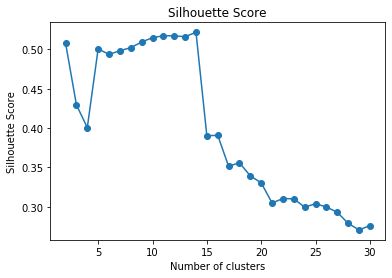

In [ ]:
graph_silhouette_score(all_honey.L_functionality_known,"Silhouette Score")

In [63]:
# Apply Agglomerative Clustering: Selected the cluster size to be close to argmax(Silhouette score)
def agglomerative_clustering(L_distance_matrix, n_clusters=15):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters,  affinity='precomputed', linkage='complete') #Alternatively linkage could also be 'single'
    labels = agg_clustering.fit_predict(L_distance_matrix)
    #print("Cluster labels- Lavenshtein Agglomarative Clustering:", labels)
    return labels

In [64]:
def agglomerative_clustering_print(L_distance_matrix):
    agg_clustering = AgglomerativeClustering(n_clusters=15,  affinity='precomputed', linkage='complete') #Alternatively linkage could also be 'single'
    labels = agg_clustering.fit_predict(L_distance_matrix)
    print("Cluster labels- Lavenshtein Agglomarative Clustering:", labels)
    return labels

In [65]:
def str_cmd_decoding(seq, dic):
    conversion = dict((v,k) for k,v in dic.items())
    ret = []
    print("seq: ", seq)

    for char in seq:
        ret.append(conversion[char])
    return ret



## Export Clustered Commands

In [68]:
def dump_csv(name, row1, row2, conv_dict):
    assert len(row1) == len(row2)

    with open(name, 'w', newline='') as file:
        writer = csv.writer(file)
        field = ['sequence', 'label', 'command']
        writer.writerow(field)
        
        for i in range(len(row1)):
            seq = row1[i]
           
            # if "_s" in name:
            #     tmp = [row1[i], row2[i]]

            #     for i in str_cmd_decoding(str(seq),conv_dict):
            #         tmp.append(label_to_ex_cmd[str(i)])

            #     writer.writerow(tmp )

            # else:
            writer.writerow([row1[i], row2[i], str_cmd_decoding(str(seq),conv_dict)] )



In [69]:
def dump_csv_count(name, row1, row2, conv_dict, p_count, e_count, c_count):
    assert len(row1) == len(row2)

    with open(name, 'w', newline='') as file:
        writer = csv.writer(file)
        field = ['sequence', 'label', 'command', "pending count", "ebilling count" , "csh count"]
        writer.writerow(field)
        print(p_count)
        for i in range(len(row1)):
            seq = str(row1[i])
            print(seq)
            writer.writerow([row1[i], row2[i], str_cmd_decoding(seq,conv_dict), p_count[seq], e_count[seq], c_count[seq] ] )



In [75]:
def dump_clustering(honey, name, k=15):
    if name == "all_normalized":
        labels = agglomerative_clustering(honey.L_functionality_known,k)

        dump_csv_count(f'{name}_fk.csv',
                 honey.functionality_cluster_known,
                 labels,
                 functionality_class_dict,
                 pending_honey.functionality_cluster_known_count_dict,
                 ebilling_honey.functionality_cluster_known_count_dict,
                 csh_honey.functionality_cluster_known_count_dict)
    else:
        labels = agglomerative_clustering(honey.L_functionality_unknown,5)
        dump_csv(f'{name}_fu.csv',honey.functionality_cluster_unknown, labels, functionality_class_dict)


In [77]:
dump_clustering(all_honey, "all_normalized",14)

defaultdict(<class 'int'>, {'d+cNZNTO]C@*Cc<CCMK9': 2909, 'PGLL[': 24, 'LLPb': 2, 'd+': 627, 'd+cN!TO]C@*Cc<CCMK9': 988, 'Q3CThh.5': 15, 'd+cNZNTO]C@*c<CCMK9': 1, 'PGLL[H': 11, 'PGLL[C': 3, 'd+cNZN@*Cc<CCK9': 1, 'd+cNZNO]C@*Cc<CCMK9': 1, 'd+cN!TO]C@*Cc<CCM9': 1, 'ff': 6, 'd+cNZNTO]C@*CcCCMK9': 1, 'd+cNZNT': 1, '%P:': 1, 'd+cNZNTO]C@Cc<CCMK9': 1, 'd+cNZNTO': 2, 'd+cN!T': 1, 'd+cNZNTO]C': 1, 'd+cNZNTOC@*Cc<CCMK9': 1, 'd+cNZNTO@*Cc<CCMK9': 1, 'd+cNZNTO]C@*Cc<CC': 1, 'd+c@*Cc<CCMK9': 1, 'PGLL&RYB,': 3, 'PGLL&RYB,S': 6, 'd+cNZNTO]C@': 1, 'd+c!O@*Cc<K9': 1, 'd+c': 4, 'd+cNZNTO]C@*Cc<': 1, 'LLE1g': 1, 'IfF': 3, 'd+cNZNTO]C@*C': 2, 'd+cNZNTO]C@*Cc': 1, '+cNZNTO]C@*Cc<CCMK9': 1, 'd+cNZN': 1, 'd+cN!TO]C@*Cc<CMK9': 2, '%P:GfLL>': 1, 'd+cNZNTO]@*Cc<CCMK9': 1, 'd+cZNTO]C@*Cc<CCMK9': 2, 'd+cNTO]C@*Cc<CCMK9': 2, 'PGLL[JJJJJJJJJ44': 3, 'd+cN': 1, 'LL^g': 1, 'd+cNZN@*Cc<CCMK9': 1, 'dcNZNTO]C@*Cc<CCMK9': 1, 'd+cN!TO]C@': 1, '+cNZO': 1, 'd+cNZNTO]C@*Cc<CMK9': 1, 'd+cN!TO]C@*': 1, '+cN!TO]C@*Cc<CCMK9': 1,